# 1 - Importação das bibliotecas

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 2 - Análise exploratória

## 2.1 - Tratamento dos dados

In [2]:
df = pd.read_csv("..\Dataset\WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Não há atributo com preenchimento vazio.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**customerID** é o ID de cada cliente e não será útil para a análise.

In [6]:
df = df.drop("customerID", axis = 1)

**TotalCharges** é um atributo númerico mas foi reconhecido como object pois há alguma string impedindo a conversão.

In [7]:
lista = []
for i in range(0, len(df)):
    if df["TotalCharges"].iloc[i].replace(".","").isnumeric() == False:
        lista.append(i)
lista

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

Os valores acima são os índices dos registros que não são numericos e estão atrapalhando a conversão.

In [8]:
valores = []
for i in range(0, len(lista)):
    valores.append(df["TotalCharges"].iloc[lista[i]])
print(valores)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


Pode-se observar que são todos valores de espaço, que serão substituídos por vazio.

In [9]:
df["TotalCharges"] = df["TotalCharges"].apply(lambda x: x if x != " " else np.nan).astype("float")

## 2.2 - Análise dos atributos númericos e categóricos 

### 2.2.1 - Atributo Alvo

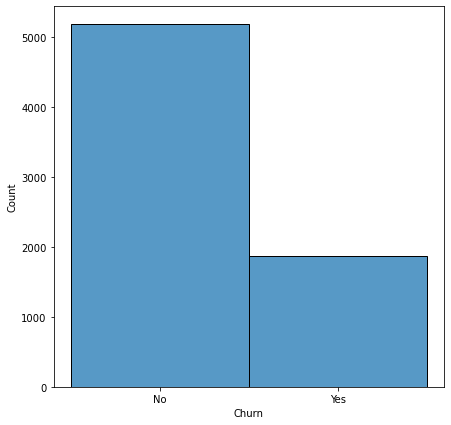

In [10]:
plt.figure(figsize=(7, 7))
sns.histplot(data = df, x = "Churn")
plt.show()

In [11]:
yes = round(df["Churn"].value_counts()[1] / len(df["Churn"]),3) * 100
no = round(df["Churn"].value_counts()[0] / len(df["Churn"]),3) * 100
print(f"Yes:{yes}%\nNo:{no}%")

Yes:26.5%
No:73.5%


- Avaliando o atributo alvo, observa-se um claro desbalanceamento no conjunto de dados.
- Para detalhar a análise dos atributos, serão divididos em categóricos e numéricos.
- O atributo alvo "churn", será transformado em atributo numérico para poder ser utilizado no treinamento do modelo e para ser comparado com os outros atributos numéricos do conjunto de dados.

In [12]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

In [13]:
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [14]:
numericos = df.select_dtypes("number")
categoricos = df.select_dtypes("object")

### 2.2.2 - Avaliando Atributos numéricos

A seguir serão avaliados os atributos numéricos para entender suas relações com a variável a ser prevista.

In [15]:
numericos.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


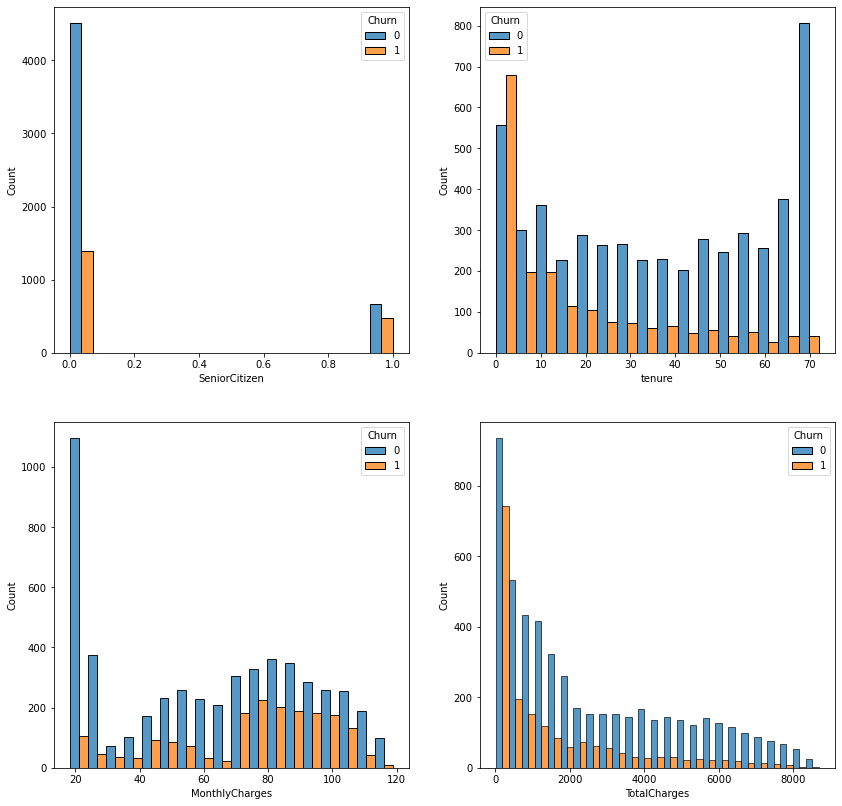

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
sns.histplot(data=df, x="SeniorCitizen", ax=axs[0, 0], hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="tenure",  ax=axs[0, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="MonthlyCharges", ax=axs[1, 0],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="TotalCharges", ax=axs[1, 1],hue = "Churn", multiple = "dodge")
plt.show()

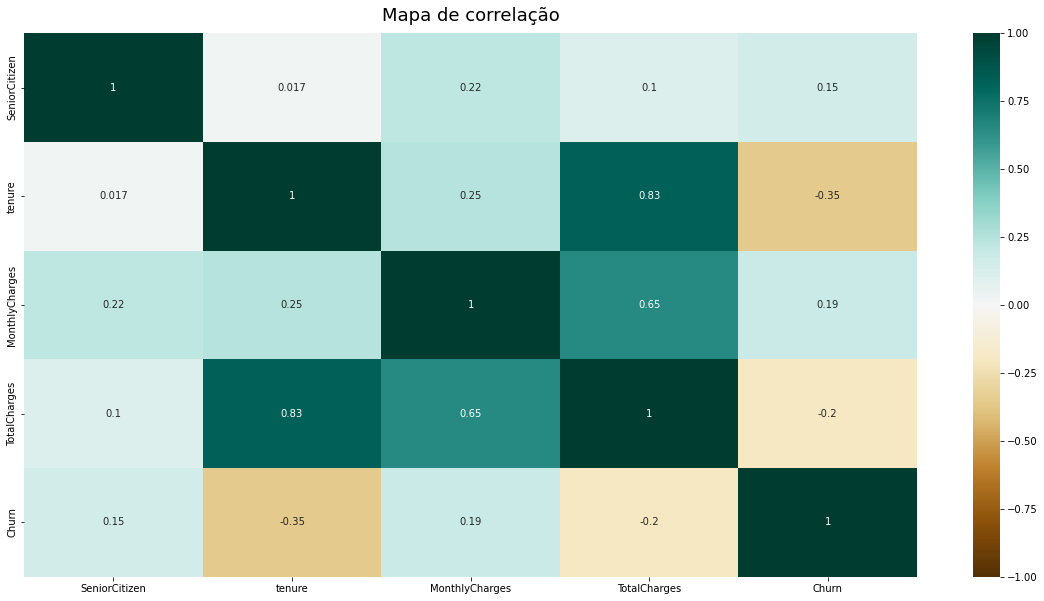

In [17]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(numericos.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Mapa de correlação', fontdict={'fontsize':18}, pad=12);
plt.show()

#### Conclusões
A partir do mapa de correlação realizado e dos histogramas, podem ser feitas algumas indagações:
1) Nenhum dos atributos possui forte correlação com a variável a ser prevista.\
2) tenure possui forte correlação com TotalCharges.\
3) MonthlyCharges possui boa correlação com TotalCharges, só que são variáveis redundantes, já que as duas indicam o custo do cliente com a empresa, só que dispostos em intervalos de tempos diferentes.\
4) Clientes idosos tem taxas de churn mais altas que clientes mais jovens.\
5) Clientes que contratam os serviços da empresa há mais tempo, tem menores taxas de churn.

### 2.2.3 - Avaliando atributos categóricos

Agora será avaliado cada atributo categórico com relação à variavel a ser prevista para compreender sua relevância.

In [18]:
for column in categoricos.columns:
    print(column,": ",categoricos[column].unique())

gender :  ['Female' 'Male']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


#### gender

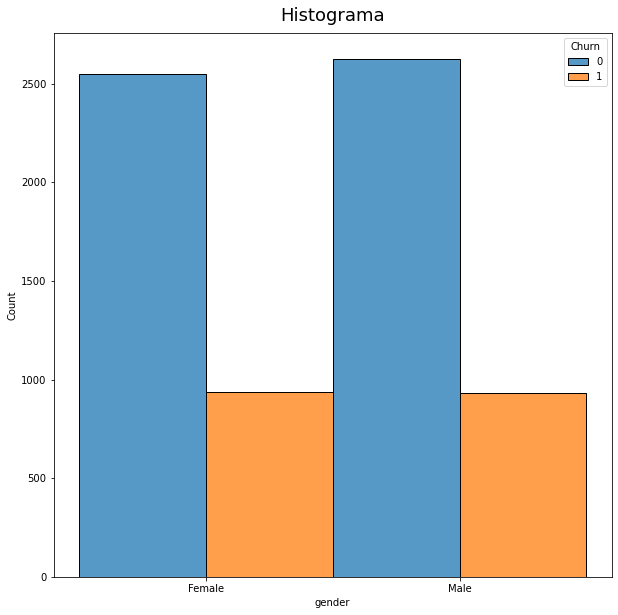

In [40]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="gender", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [41]:
Female = round(df[df["gender"] == "Female"]["Churn"].value_counts()[1] / len(df[df["gender"] == "Female"])*100,2)
Male = round(df[df["gender"] == "Male"]["Churn"].value_counts()[1] / len(df[df["gender"] == "Male"])*100,2)
print(f"A proporção da rotatividade de homens é {Male}% e de mulheres é {Female}%.")

A proporção da rotatividade de homens é 26.16% e de mulheres é 26.92%.


Não há ganho de informação do gênero com relação à rotatividade de clientes.

#### Partner

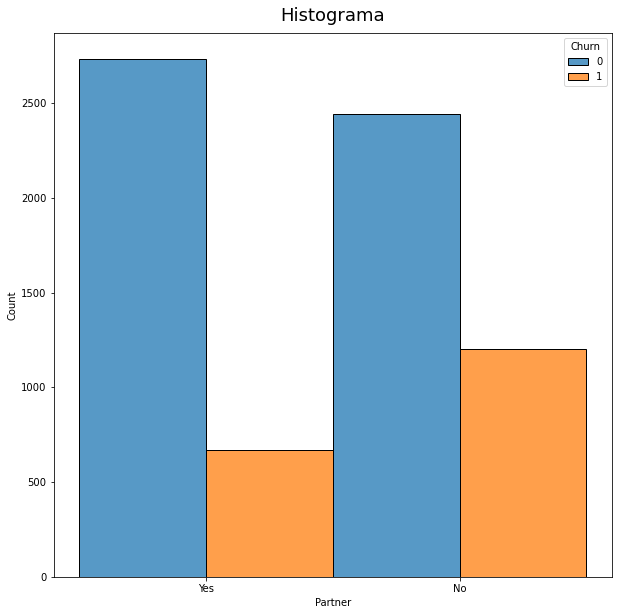

In [42]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="Partner", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [43]:
Yes = round(df[df["Partner"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["Partner"] == "Yes"])*100,2)
No = round(df[df["Partner"] == "No"]["Churn"].value_counts()[1] / len(df[df["Partner"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que tem parceiro é {Yes}% e de pessoas que não tem é {No}%.")

A proporção da rotatividade de pessoas que tem parceiro é 19.66% e de pessoas que não tem é 32.96%.


Clientes que não são casados tem maior chance de rotatividade.

#### Dependents

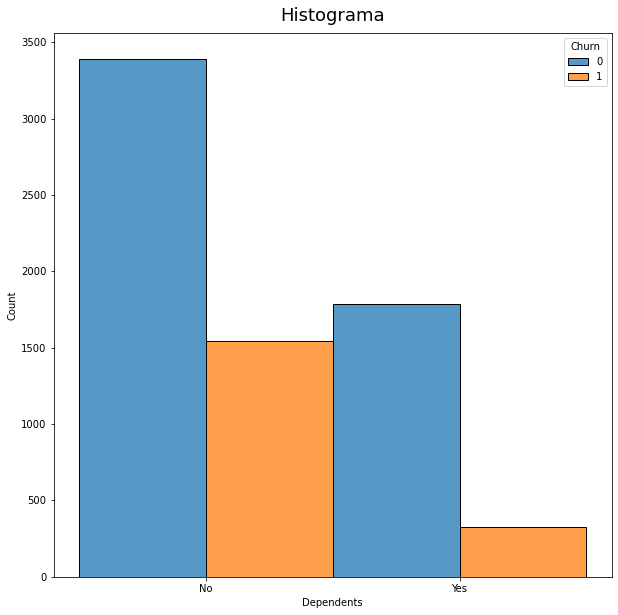

In [44]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="Dependents", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [45]:
Yes = round(df[df["Dependents"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["Dependents"] == "Yes"])*100,2)
No = round(df[df["Dependents"] == "No"]["Churn"].value_counts()[1] / len(df[df["Dependents"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que tem filhos é {Yes}% e de pessoas que não tem é {No}%.")

A proporção da rotatividade de pessoas que tem filhos é 15.45% e de pessoas que não tem é 31.28%.


Clientes que não tem filhos tem chances bem maiores de rotatividade.

#### PhoneService

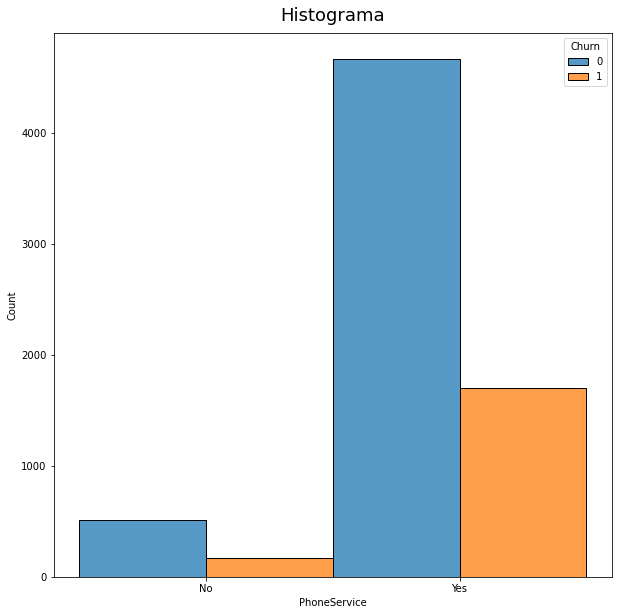

In [46]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="PhoneService", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [47]:
Yes = round(df[df["PhoneService"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["PhoneService"] == "Yes"])*100,2)
No = round(df[df["PhoneService"] == "No"]["Churn"].value_counts()[1] / len(df[df["PhoneService"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas possuem o plano é {Yes}% e de pessoas que não tem é {No}%.")

A proporção da rotatividade de pessoas possuem o plano é 26.71% e de pessoas que não tem é 24.93%.


Não há diferença relevante na proporção de rotatividade entre as pessoas que utilizam o plano ou não.

#### MultipleLines

Nesse atributo os valores 'No phone service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [48]:
df["MultipleLines"] = df["MultipleLines"].replace('No phone service','No')

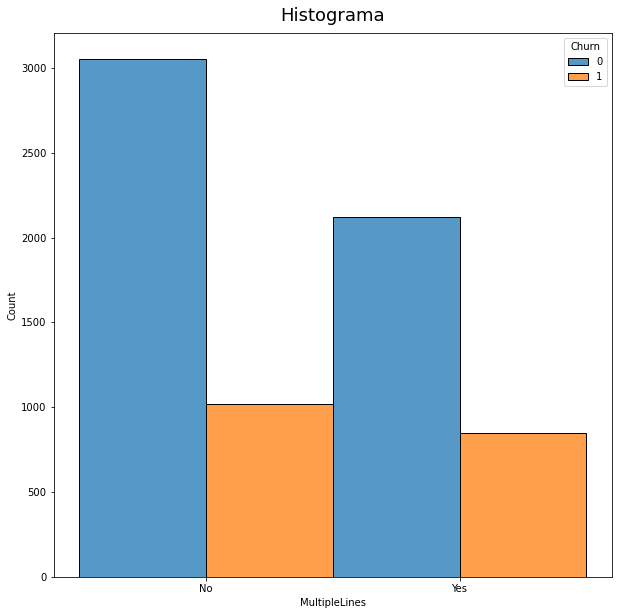

In [49]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="MultipleLines", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [50]:
Yes = round(df[df["MultipleLines"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["MultipleLines"] == "Yes"])*100,2)
No = round(df[df["MultipleLines"] == "No"]["Churn"].value_counts()[1] / len(df[df["MultipleLines"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas possuem múltiplas linhas telefônicas é {Yes}% e de pessoas que não tem é {No}%.")

A proporção da rotatividade de pessoas possuem múltiplas linhas telefônicas é 28.61% e de pessoas que não tem é 25.02%.


Há muito pouca diferença de rotatividade entre as pessoas que possuem mútiplas linhas telefônicas.

#### InternetService

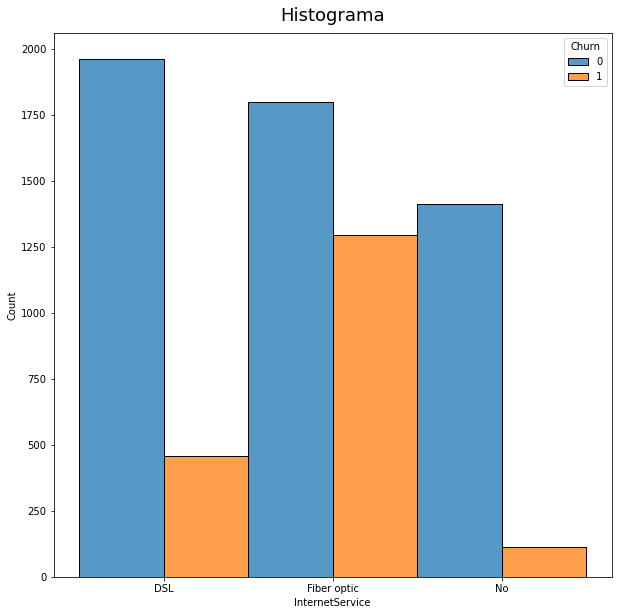

In [51]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="InternetService", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [52]:
DSL = round(df[df["InternetService"] == "DSL"]["Churn"].value_counts()[1] / len(df[df["InternetService"] == "DSL"])*100,2)
FibraOtica = round(df[df["InternetService"] == "Fiber optic"]["Churn"].value_counts()[1] / len(df[df["InternetService"] == "Fiber optic"])*100,2)
No = round(df[df["InternetService"] == "No"]["Churn"].value_counts()[1] / len(df[df["InternetService"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas assinam internet DSL é {DSL}%, que assinam fibra ótica é {FibraOtica}% e que não assinam é {No}%.")

A proporção da rotatividade de pessoas assinam internet DSL é 18.96%, que assinam fibra ótica é 41.89% e que não assinam é 7.4%.


Pessoas que assinam fibra ótica tem chance bem maior de rotatividade, enquanto quem não assina tem chance bem menor.

#### OnlineSecurity

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [53]:
df["OnlineSecurity"] = df["OnlineSecurity"].replace("No internet service","No")

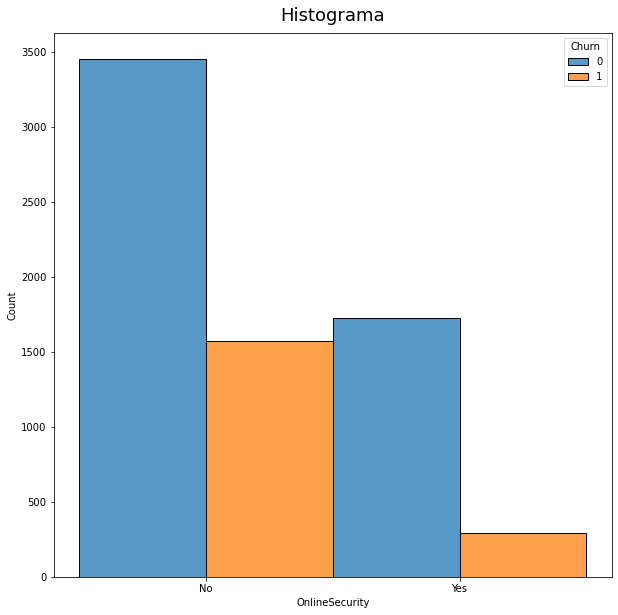

In [54]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="OnlineSecurity", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [55]:
Yes = round(df[df["OnlineSecurity"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["OnlineSecurity"] == "Yes"])*100,2)
No = round(df[df["OnlineSecurity"] == "No"]["Churn"].value_counts()[1] / len(df[df["OnlineSecurity"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que assinam seguraça virtual extra {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que assinam seguraça virtual extra 14.61% e de pessoas que não é 31.33%.


Quem não assina por segurança extra, tem chance bem maior de rotatividade.

#### OnlineBackup

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [56]:
df["OnlineBackup"] = df["OnlineBackup"].replace("No internet service","No")

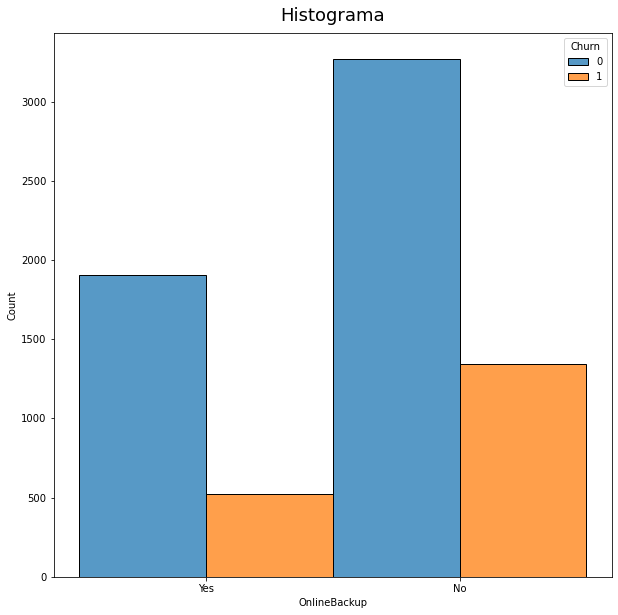

In [57]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="OnlineBackup", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [58]:
Yes = round(df[df["OnlineBackup"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["OnlineBackup"] == "Yes"])*100,2)
No = round(df[df["OnlineBackup"] == "No"]["Churn"].value_counts()[1] / len(df[df["OnlineBackup"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que assinam backup {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que assinam backup 21.53% e de pessoas que não é 29.17%.


Há uma chance maior de rotatividade para pessoas que não assinam backup. 

#### DeviceProtection

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [59]:
df["DeviceProtection"] = df["DeviceProtection"].replace("No internet service","No")

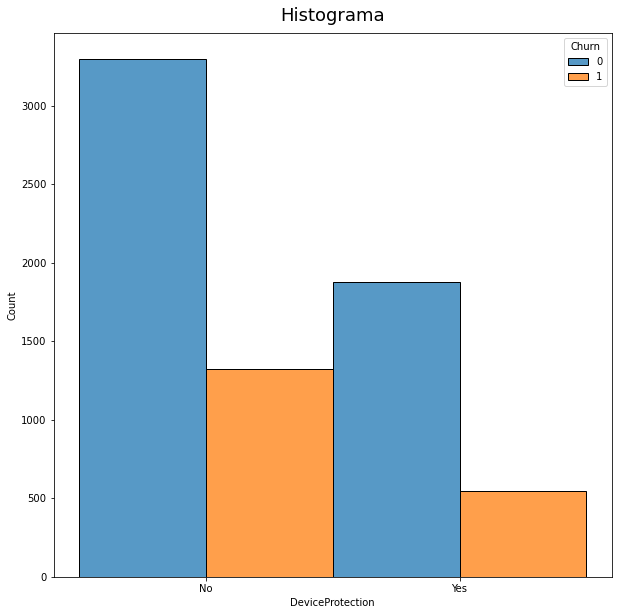

In [60]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="DeviceProtection", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [61]:
Yes = round(df[df["DeviceProtection"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["DeviceProtection"] == "Yes"])*100,2)
No = round(df[df["DeviceProtection"] == "No"]["Churn"].value_counts()[1] / len(df[df["DeviceProtection"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que assinam segurança extra para o equipamento de internet é {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que assinam segurança extra para o equipamento de internet é 22.5% e de pessoas que não é 28.65%.


Há uma chance maior de rotatividade para pessoas que não assinam segurança extra para o equipamento de internet.

#### TechSupport

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [62]:
df["TechSupport"] = df["TechSupport"].replace("No internet service","No")

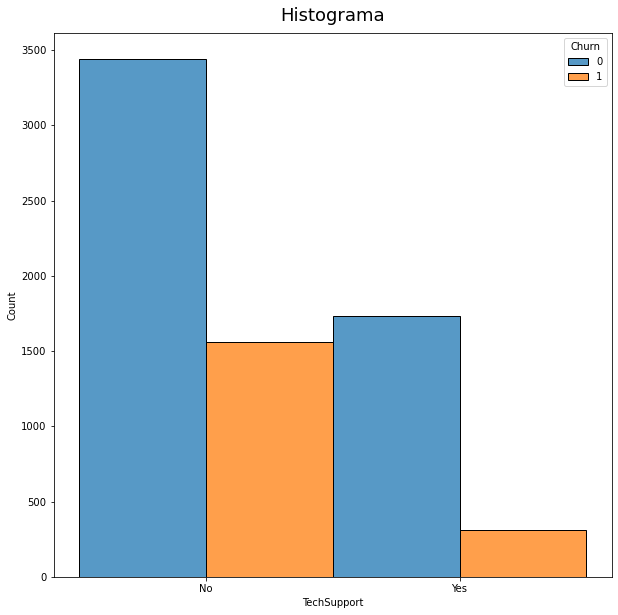

In [63]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="TechSupport", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [64]:
Yes = round(df[df["TechSupport"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["TechSupport"] == "Yes"])*100,2)
No = round(df[df["TechSupport"] == "No"]["Churn"].value_counts()[1] / len(df[df["TechSupport"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que assinam assistência técnica extra é {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que assinam assistência técnica extra é 15.17% e de pessoas que não é 31.19%.


Pessoas que não assinam por assistência técnica extra tem chance bem maior de rotatividade.

#### StreamingTV

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [65]:
df["StreamingTV"] = df["StreamingTV"].replace("No internet service","No")

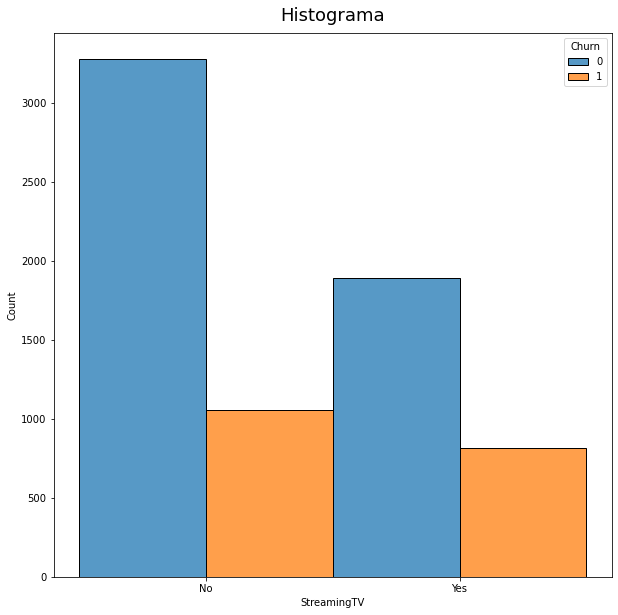

In [66]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="StreamingTV", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [67]:
Yes = round(df[df["StreamingTV"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["StreamingTV"] == "Yes"])*100,2)
No = round(df[df["StreamingTV"] == "No"]["Churn"].value_counts()[1] / len(df[df["StreamingTV"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que usam a internet para assistir programas de TV em serviço de streaming é {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que usam a internet para assistir programas de TV em serviço de streaming é 30.07% e de pessoas que não é 24.33%.


Pessoas que usam a internet para assistir programas de TV em serviços de streaming tem mais chance de rotatividade.

#### StreamingMovies

Nesse atributo os valores 'No internet service' e 'No' entregam a mesma informação, então serão substituídos pelo mesmo valor. 

In [68]:
df["StreamingMovies"] = df["StreamingMovies"].replace("No internet service","No")

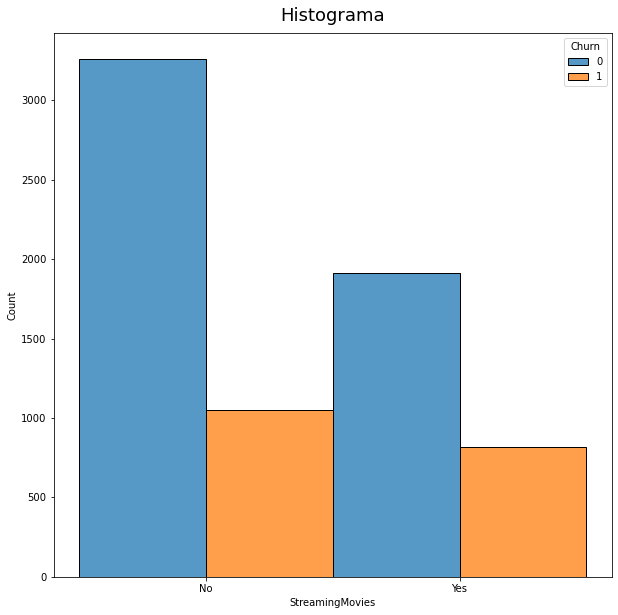

In [69]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="StreamingMovies", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [70]:
Yes = round(df[df["StreamingMovies"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["StreamingMovies"] == "Yes"])*100,2)
No = round(df[df["StreamingMovies"] == "No"]["Churn"].value_counts()[1] / len(df[df["StreamingMovies"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que usam a internet para assistir filmes em serviço de streaming é {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que usam a internet para assistir filmes em serviço de streaming é 29.94% e de pessoas que não é 24.38%.


Pessoas que usam a internet para assistir filmes em serviços de streaming tem mais chance de rotatividade.\
Esse atributo é redundante em relação ao anterior, já que trás praticamente a mesma informação com a mesma proporção.

#### Contract

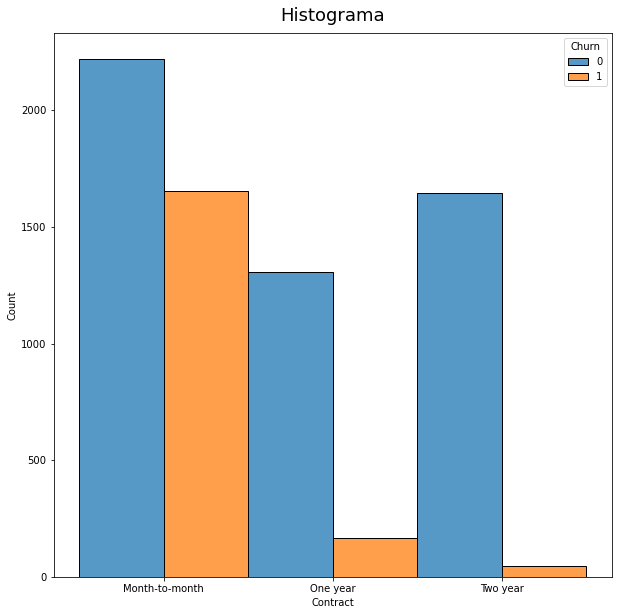

In [71]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="Contract", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [72]:
Mensal = round(df[df["Contract"] == "Month-to-month"]["Churn"].value_counts()[1] / len(df[df["Contract"] == "Month-to-month"])*100,2)
Anual = round(df[df["Contract"] == "One year"]["Churn"].value_counts()[1] / len(df[df["Contract"] == "One year"])*100,2)
Bianual = round(df[df["Contract"] == "Two year"]["Churn"].value_counts()[1] / len(df[df["Contract"] == "Two year"])*100,2)
print(f"A proporção da rotatividade de pessoas que tem contrato mensal é {Mensal}%,que tem contrato anual é {Anual}% e contrato Bianual é {Bianual}%.")

A proporção da rotatividade de pessoas que tem contrato mensal é 42.71%,que tem contrato anual é 11.27% e contrato Bianual é 2.83%.


Pessoas com modelo de contrato mensal tem a maior proporção de rotatividade, enquanto quem possui contrato bianual, tem a menor chance.

#### PaperlessBilling

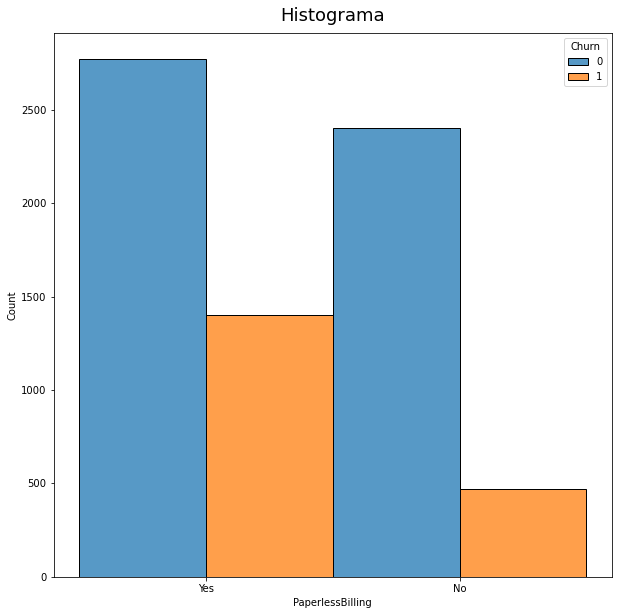

In [73]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="PaperlessBilling", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [74]:
Yes = round(df[df["PaperlessBilling"] == "Yes"]["Churn"].value_counts()[1] / len(df[df["PaperlessBilling"] == "Yes"])*100,2)
No = round(df[df["PaperlessBilling"] == "No"]["Churn"].value_counts()[1] / len(df[df["PaperlessBilling"] == "No"])*100,2)
print(f"A proporção da rotatividade de pessoas que preferem pagar contas de forma virtual é {Yes}% e de pessoas que não é {No}%.")

A proporção da rotatividade de pessoas que preferem pagar contas de forma virtual é 33.57% e de pessoas que não é 16.33%.


Clientes que optam por as pagar contas online tem chance de rotatividade bem maior.

#### PaymentMethod

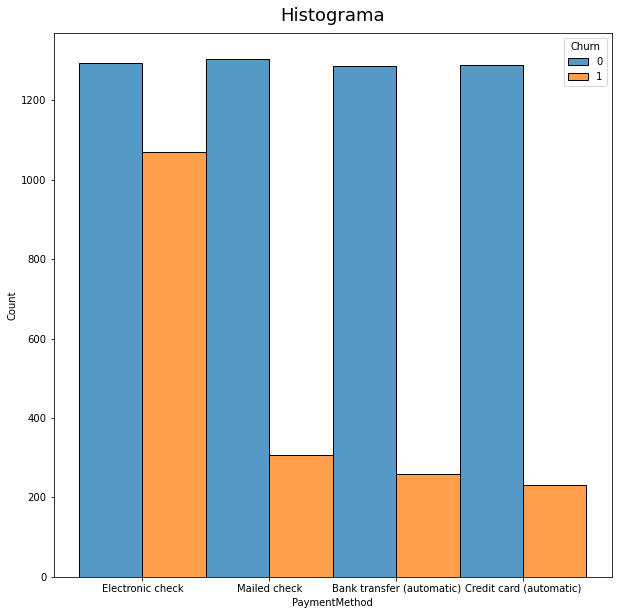

In [75]:
plt.figure(figsize=(10, 10))
histplot = sns.histplot(data=df, x="PaymentMethod", hue = "Churn", multiple = "dodge")
histplot.set_title('Histograma', fontdict={'fontsize':18}, pad=12);
plt.show()

In [76]:
EC = round(df[df["PaymentMethod"] == "Electronic check"]["Churn"].value_counts()[1] / len(df[df["PaymentMethod"] == "Electronic check"])*100,2)
MC = round(df[df["PaymentMethod"] == "Mailed check"]["Churn"].value_counts()[1] / len(df[df["PaymentMethod"] == "Mailed check"])*100,2)
BT = round(df[df["PaymentMethod"] == "Bank transfer (automatic)"]["Churn"].value_counts()[1] / len(df[df["PaymentMethod"] == "Bank transfer (automatic)"])*100,2)
CC = round(df[df["PaymentMethod"] == "Credit card (automatic)"]["Churn"].value_counts()[1] / len(df[df["PaymentMethod"] == "Credit card (automatic)"])*100,2)
print(f"A proporção da rotatividade de pessoas que optam por cheque eletrônico é {EC}%,que optam por cheque por email é {MC}%,\n que optam por transferência bancária é {BT}% e que optam por cartão de crédito é {CC}%.")

A proporção da rotatividade de pessoas que optam por cheque eletrônico é 45.29%,que optam por cheque por email é 19.11%,
 que optam por transferência bancária é 16.71% e que optam por cartão de crédito é 15.24%.


Os clientes que optam por utilizar o pagamento das contas por cheque eletônico tem chances muito altas de rotatividade.

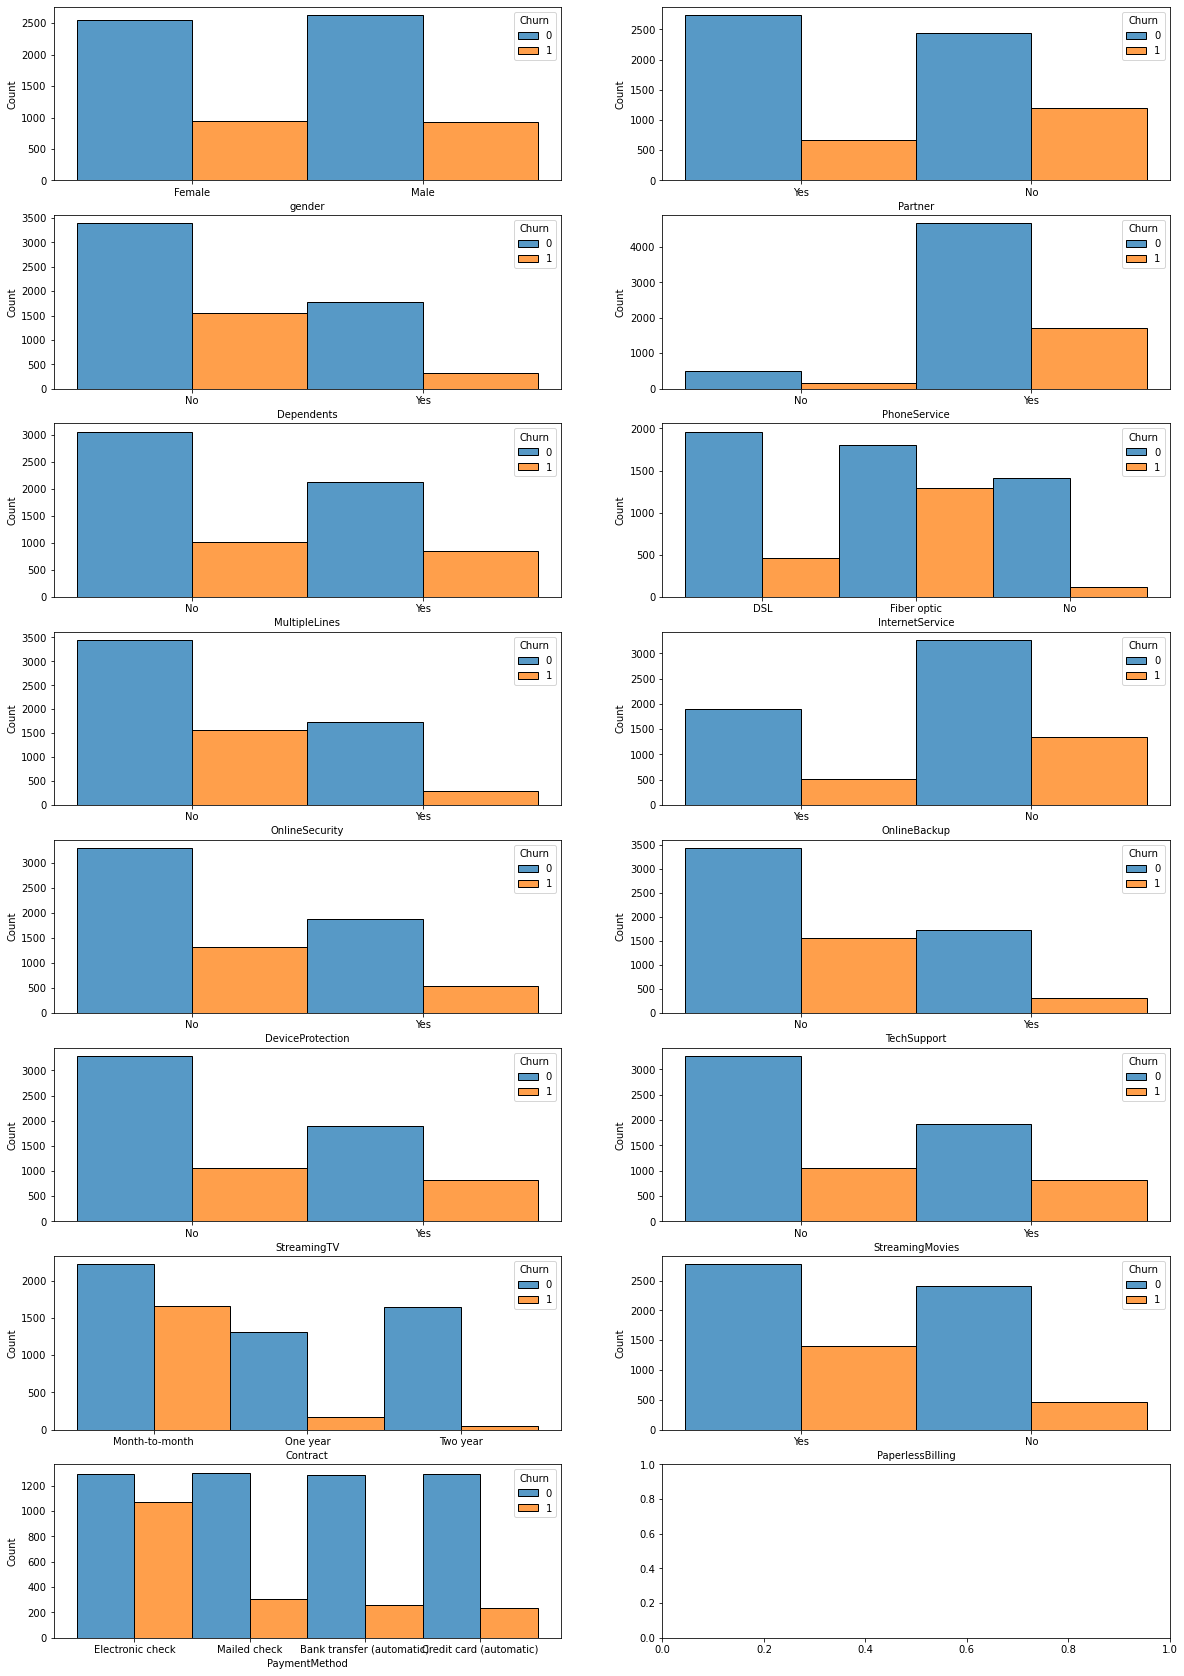

In [89]:
fig, axs = plt.subplots(8, 2, figsize=(20, 30))
sns.histplot(data=df, x="gender", ax=axs[0, 0], hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="Partner",  ax=axs[0, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="Dependents", ax=axs[1, 0],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="PhoneService", ax=axs[1, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="MultipleLines", ax=axs[2, 0], hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="InternetService",  ax=axs[2, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="OnlineSecurity", ax=axs[3, 0],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="OnlineBackup", ax=axs[3, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="DeviceProtection", ax=axs[4, 0], hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="TechSupport",  ax=axs[4, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="StreamingTV", ax=axs[5, 0],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="StreamingMovies", ax=axs[5, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="Contract", ax=axs[6, 0], hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="PaperlessBilling",  ax=axs[6, 1],hue = "Churn", multiple = "dodge")
sns.histplot(data=df, x="PaymentMethod",  ax=axs[7, 0],hue = "Churn", multiple = "dodge")
histplot.set_title('Histogramas', fontdict={'fontsize':18}, pad=12);
plt.show()

#### Conclusões

**1) gender:**  Não há diferença praticamente entre os genêros para a rotatividade de clientes.\
**2) Partner:** Pessoas que não tem parceiro tem chances bem maiores de rotatividade.\
**3) Dependents:** Pessoas que não tem dependentes tem chances bem maiores de rotatividade.\
**4) PhoneService:** As pessoas que assinam tem chance levemente maior de rotatividade, mas é praticamente irrelevante.\
**5) MultipleLines:** A proporção de pessoas que assinam múltiplas linhas telefônicas é um pouco maior.\
**6) InternetService:** As pessoas que assinam internet de fibra ótica, tem chance muito maior de rotatividade.\
**7) OnlineSecurity:** As pessoas que não assinam o pacote de segurança de internet extra tem chance bem maior de rotatividade.\
**8) OnlineBackup:** As pessoas que não assinam o serviço de backup online tem chance maior de rotatividade.\
**9) DeviceProtection:** As pessoas que não assinam o pacote extra de segurança do equipamento tem chance maior de rotatividade.\
**10) TechSupport:** As pessoas que não assinam assistência técnica extra tem chances bem maiores de rotatividade.\
**11) StreamingTV:** As pessoas que assinam a internet para consumir programas de TV em serviços de streaming tem chance maior de rotatividade.\
**12) StreamingMovies:** As pessoas que assinam a internet para consumir filmes em serviços de streaming tem chance maior de rotatividade. Este atributo tem as mesmas chances e praticamente trás a mesma informação que **StreamingTV**, então será excluído.\
**13) Contract:** As pessoas que assinam o modelo de contrato mensal tem chances bem maiores de rotatividade.\
**14) PaperlessBilling:** As pessoas que pagam as contas de forma virtual tem chance bem maior de rotatividade.\
**15) PaymentMethod:** As pessoas que optam por pagar as contas por cheque eletrônico tem chances bem maiores de rotatividade.

Os atributos **gender** e **PhoneService** serão excluídos da análise porque não trazem informações extras relevantes para a variável a ser prevista.

# 3 - Treinamento dos modelos de aprendizagem de máquina

## 3.1 - Preparação do conjunto de dados

In [90]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0
7,Female,0,No,No,10,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


Os atributos que possuem o valor *No internet service* serão substituídos por *No*. 

In [91]:
df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

A função *get_dummies* transforma os atributos categóricos em numéricos para poder treinar o modelo de aprendizagem de máquina.

In [92]:
df = pd.get_dummies(df)
df.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [102]:
for column in df.columns:
    print(column,": ",df[column].unique())

SeniorCitizen :  [0 1]
tenure :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
MonthlyCharges :  [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges :  [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn :  [0 1]
gender_Female :  [1 0]
gender_Male :  [0 1]
Partner_No :  [0 1]
Partner_Yes :  [1 0]
Dependents_No :  [1 0]
Dependents_Yes :  [0 1]
PhoneService_No :  [1 0]
PhoneService_Yes :  [0 1]
MultipleLines_No :  [1 0]
MultipleLines_Yes :  [0 1]
InternetService_DSL :  [1 0]
InternetService_Fiber optic :  [0 1]
InternetService_No :  [0 1]
OnlineSecurity_No :  [1 0]
OnlineSecurity_Yes :  [0 1]
OnlineBackup_No :  [0 1]
OnlineBackup_Yes :  [1 0]
DeviceProtection_No :  [1 0]
DeviceProtection_Yes :  [0 1]
TechSupport_No :  [1 0]
TechSupport_Yes :  [0 1]
StreamingTV_No :  [1 0]
StreamingTV_Yes :  [0 1]
Strea

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   MonthlyCharges                           7043 non-null   float64
 3   TotalCharges                             7032 non-null   float64
 4   Churn                                    7043 non-null   int32  
 5   gender_Female                            7043 non-null   uint8  
 6   gender_Male                              7043 non-null   uint8  
 7   Partner_No                               7043 non-null   uint8  
 8   Partner_Yes                              7043 non-null   uint8  
 9   Dependents_No                            7043 non-null   uint8  
 10  Dependents_Yes                           7043 no

Agora deve-se separar a variável alvo e os outros atributos e dividir o conjunto de dados em treinamento e teste.

In [104]:
X= df.drop('Churn', axis=1)
y= df['Churn']

In [105]:
X= df.drop('Churn', axis=1)
y= df['Churn']
df_x_treinamento, df_x_teste, df_y_treinamento, df_y_teste = train_test_split(X, y, test_size=0.3, random_state=1)

O algoritmo que será usado para treinar é o LightGBM classifier, já que é bem leve, principalmente em comparação a XGBoost, por ser um algoritmo de boosting, que costuma performar bem com conjuntos de dados desbalanceados e por ter o hiperparâmetro *scale_pos_weight* que atribui pesos, privilegiando a classe com menor proporção da variável alvo.

## 3.2 - Treinando os modelos

### 3.2.1 - Modelo sem hiperparametros ajustados

In [111]:
lgbm = LGBMClassifier()
lgbm.fit(df_x_treinamento, df_y_treinamento)
previsao= lgbm.predict(df_x_teste)

In [112]:
accuracy= []
recall =[]
roc_auc= []
precision = []
accuracy.append(round(accuracy_score(df_y_teste, previsao),4))
recall.append(round(recall_score(df_y_teste, previsao),4))
roc_auc.append(round(roc_auc_score(df_y_teste, previsao),4))
precision.append(round(precision_score(df_y_teste, previsao),4))

In [114]:
model_names = ['LightGBM_padrão']
result_dfp = pd.DataFrame({'Acurácia':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precisão':precision}, index=model_names)
result_dfp

,Acurácia,Recall,Roc_Auc,Precisão
LightGBM_padrão,0.8045,0.5568,0.7219,0.6216


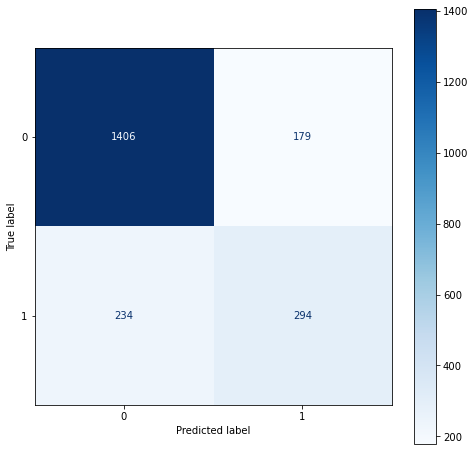

In [115]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbm, df_x_teste, df_y_teste, cmap=plt.cm.Blues, ax=ax);

### 3.2.2 - Otimizando os hiperparâmetros

In [156]:
parametros= {'num_leaves': [50, 100, 31],
             'learning_rate': [0.5, 1.0, 0.1],
             'n_estimators': [100, 150, 200],
             'min_split_gain': [0, 0.5, 1.0],
             'max_depth': [-1, -2, 5, 10],
             'min_child_samples': [20, 30, 40]}

Para encontrar os hiperparâmetros mais otimizados, será utilizado o GridSearchCV, que irá testar o modelo com cada um dos hiperparâmetros definidos acima.

In [157]:
parametros= {'num_leaves': [50, 100, 31],
             'learning_rate': [0.5, 1.0, 0.1],
             'n_estimators': [100, 150, 200],
             'min_split_gain': [0, 0.5, 1.0],
             'max_depth': [-1, -2, 5, 10],
             'min_child_samples': [20, 30, 40]}
grid_search = GridSearchCV(estimator=LGBMClassifier(), param_grid=parametros)
grid_search.fit(df_x_treinamento, df_y_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_split_gain': 1.0, 'n_estimators': 100, 'num_leaves': 50}
0.7977687626774849


### 3.2.3 - Modelo com *scale_pos_weight* = 1

In [116]:
lgbm = LGBMClassifier(learning_rate= 0.1, max_depth= 5, min_child_samples= 20, min_split_gain= 1.0, n_estimators= 100, num_leaves= 50, scale_pos_weight=1)
lgbm.fit(df_x_treinamento, df_y_treinamento)
previsao= lgbm.predict(df_x_teste)

In [117]:
accuracy= []
recall =[]
roc_auc= []
precision = []
accuracy.append(round(accuracy_score(df_y_teste, previsao),4))
recall.append(round(recall_score(df_y_teste, previsao),4))
roc_auc.append(round(roc_auc_score(df_y_teste, previsao),4))
precision.append(round(precision_score(df_y_teste, previsao),4))

In [118]:
model_names = ['LightGBM_1']
result_df1 = pd.DataFrame({'Acurácia':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precisão':precision}, index=model_names)
result_df1

,Acurácia,Recall,Roc_Auc,Precisão
LightGBM_1,0.8102,0.5739,0.7314,0.6326


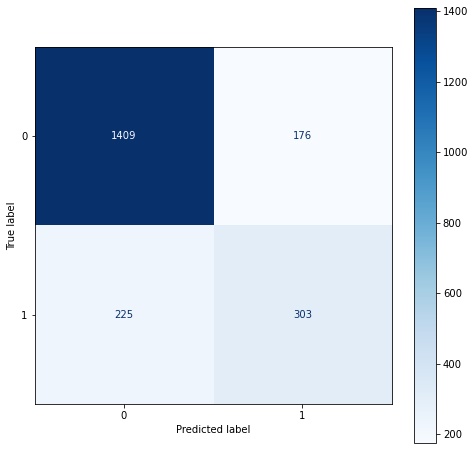

In [119]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbm, df_x_teste, df_y_teste, cmap=plt.cm.Blues, ax=ax);

### 3.2.3 - Modelo com *scale_pos_weight* = 3

In [120]:
lgbm = LGBMClassifier(learning_rate= 0.1, max_depth= 5, min_child_samples= 20, min_split_gain= 1.0, n_estimators= 100, num_leaves= 50, scale_pos_weight=3)
lgbm.fit(df_x_treinamento, df_y_treinamento)
previsao= lgbm.predict(df_x_teste)

In [121]:
accuracy= []
recall =[]
roc_auc= []
precision = []
accuracy.append(round(accuracy_score(df_y_teste, previsao),4))
recall.append(round(recall_score(df_y_teste, previsao),4))
roc_auc.append(round(roc_auc_score(df_y_teste, previsao),4))
precision.append(round(precision_score(df_y_teste, previsao),4))

In [122]:
model_names = ['LightGBM_3']
result_df3 = pd.DataFrame({'Acurácia':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precisão':precision}, index=model_names)
result_df3

,Acurácia,Recall,Roc_Auc,Precisão
LightGBM_3,0.7525,0.8258,0.7769,0.5029


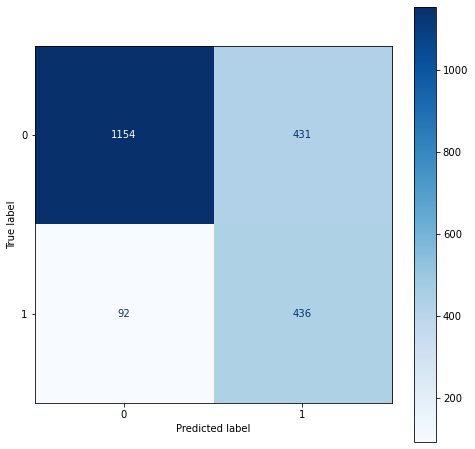

In [123]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbm, df_x_teste, df_y_teste, cmap=plt.cm.Blues, ax=ax);

### 3.2.3 - Modelo com *scale_pos_weight* = 5

In [124]:
lgbm = LGBMClassifier(learning_rate= 0.1, max_depth= 5, min_child_samples= 20, min_split_gain= 1.0, n_estimators= 100, num_leaves= 50, scale_pos_weight=5)
lgbm.fit(df_x_treinamento, df_y_treinamento)
previsao= lgbm.predict(df_x_teste)

In [125]:
accuracy= []
recall =[]
roc_auc= []
precision = []
accuracy.append(round(accuracy_score(df_y_teste, previsao),4))
recall.append(round(recall_score(df_y_teste, previsao),4))
roc_auc.append(round(roc_auc_score(df_y_teste, previsao),4))
precision.append(round(precision_score(df_y_teste, previsao),4))

In [126]:
model_names = ['LightGBM_5']
result_df5 = pd.DataFrame({'Acurácia':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precisão':precision}, index=model_names)
result_df5

,Acurácia,Recall,Roc_Auc,Precisão
LightGBM_5,0.7042,0.8788,0.7624,0.4527


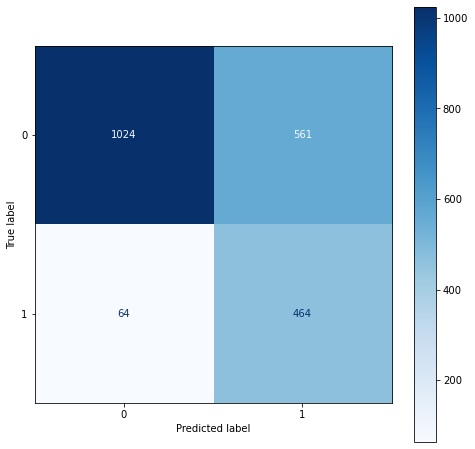

In [127]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbm, df_x_teste, df_y_teste, cmap=plt.cm.Blues, ax=ax);

### 3.2.4 - Comparação entre os modelos

In [128]:
pd.concat([result_dfp, result_df1, result_df3, result_df5])

,Acurácia,Recall,Roc_Auc,Precisão
LightGBM_padrão,0.8045,0.5568,0.7219,0.6216
LightGBM_1,0.8102,0.5739,0.7314,0.6326
LightGBM_3,0.7525,0.8258,0.7769,0.5029
LightGBM_5,0.7042,0.8788,0.7624,0.4527
